#Trabalho Final - Machine Learning Aplicado 2

##Descrição do Dataset

O dataset escolhido para o trabalho foi adquirido na plataforma Kaggle. Lá, o dataset atende pelo título [Android Malware Dataset for Machine Learning](https://www.kaggle.com/shashwatwork/android-malware-dataset-for-machine-learning), mantido por by Shashwat Tiwari.

O dataset possui 215 atributos extraídos de 15.036 softwares (5.560 softwares de malware do projeto Drebin e 9.476 softwares benignos). Um atributo a mais foi criado, contendo a classificação do software em *B* (benigno) ou *S* (malware). Ainda possui um arquivo de suporte contendo a descrição dos atributos, obtidos através da análise de código estático de aplicativos Android.

Este dataset foi desenvolvido para um artigo científico publicado em 2019 na IEEE TRANSACTIONS ON CYBERNETICS (VOL. 49, NO. 2), entitulado de "DroidFusion: A Novel Multilevel Classifier Fusion Approach for Android Malware Detection".

##Bibliotecas Utilizadas

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import CategoricalNB, BernoulliNB
from sklearn.feature_selection import *
from sklearn.model_selection import KFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


##Carregando o Dataset

In [ ]:
drive.mount('/content/drive/')
url1= '/content/drive/MyDrive/Colab Notebooks/ml_aplicado_2/FinalTerm/drebin-215-dataset-5560malware-9476-benign.csv'

df_original = pd.read_csv(url1)
df_original

Mounted at /content/drive/


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (92) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,Ljava.net.URLDecoder,android.content.pm.Signature,android.telephony.SmsManager,READ_PHONE_STATE,getBinder,ClassLoader,Landroid.content.Context.registerReceiver,Ljava.lang.Class.getField,Landroid.content.Context.unregisterReceiver,GET_ACCOUNTS,RECEIVE_SMS,Ljava.lang.Class.getDeclaredField,READ_SMS,getCallingUid,Ljavax.crypto.spec.SecretKeySpec,android.intent.action.BOOT_COMPLETED,USE_CREDENTIALS,MANAGE_ACCOUNTS,android.content.pm.PackageInfo,KeySpec,TelephonyManager.getLine1Number,DexClassLoader,HttpGet.init,SecretKey,Ljava.lang.Class.getMethod,System.loadLibrary,android.intent.action.SEND,Ljavax.crypto.Cipher,WRITE_SMS,READ_SYNC_SETTINGS,...,BIND_TEXT_SERVICE,INSTALL_LOCATION_PROVIDER,android.intent.action.CALL_BUTTON,android.intent.action.SCREEN_OFF,findClass,SYSTEM_ALERT_WINDOW,MOUNT_FORMAT_FILESYSTEMS,CHANGE_CONFIGURATION,CLEAR_APP_USER_DATA,intent.action.RUN,android.intent.action.SET_WALLPAPER,CHANGE_WIFI_STATE,READ_FRAME_BUFFER,ACCESS_SURFACE_FLINGER,Runtime.loadLibrary,BROADCAST_SMS,EXPAND_STATUS_BAR,INTERNAL_SYSTEM_WINDOW,android.intent.action.BATTERY_LOW,SET_ACTIVITY_WATCHER,WRITE_CONTACTS,android.intent.action.ACTION_POWER_CONNECTED,BIND_VPN_SERVICE,DISABLE_KEYGUARD,ACCESS_MOCK_LOCATION,GET_PACKAGE_SIZE,MODIFY_PHONE_STATE,CHANGE_COMPONENT_ENABLED_STATE,CLEAR_APP_CACHE,SET_ORIENTATION,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,S
1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,S
2,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,S
3,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,S
4,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15031,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,0,1,1,0,0,0,1,1,0,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,B
15032,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,B
15033,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,B
15034,1,1,1,1,1,1,0,1,1,1,1,1,0,0,0,1,1,1,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,B


In [ ]:
#Carregando o dataset contendo a descrição dos atributos:
url2= '/content/drive/MyDrive/Colab Notebooks/ml_aplicado_2/FinalTerm/dataset-features-categories.csv'

df_desc = pd.read_csv(url2, names=['feature', 'description'])
df_desc

,feature,description
0,transact,API call signature
1,onServiceConnected,API call signature
2,bindService,API call signature
3,attachInterface,API call signature
4,ServiceConnection,API call signature
...,...,...
211,ACCESS_FINE_LOCATION,Manifest Permission
212,SET_WALLPAPER_HINTS,Manifest Permission
213,SET_PREFERRED_APPLICATIONS,Manifest Permission
214,WRITE_SECURE_SETTINGS,Manifest Permission


In [ ]:
df_desc['description'].unique()

array(['API call signature', 'Manifest Permission', 'Intent',
       'Commands signature', 'B=Benign; S=Malware'], dtype=object)

##Explorando o Dataset

Esta seção procura explorar o dataset de forma integral, afim de definir o tratamento de dados necessário. 

In [ ]:
#Definindo variáveis auxiliares relativas aos nomes das colunas.

colunas = df_original.columns.to_list()

target = colunas[len(colunas)-1] #atributo target
attrs = colunas[0:len(colunas)-1] #demais atributos

###Linhas X Colunas

In [ ]:
print("Qntd. Linhas:", df_original.shape[0])
print("Qntd. Colunas:", df_original.shape[1])

Qntd. Linhas: 15036
Qntd. Colunas: 216


###Verificação de Registros Duplicados

Na verificação de registros duplicados, consta que existem 6.865 linhas estão repetidas, onde 3.839 pertencem à classe `S` (malwares) e 3.026 pertencem à classe `B` (softwares benignos).

In [ ]:
duplicados= df_original[df_original.duplicated(keep='first')]
print("Quantia de registros duplicados:", duplicados.shape[0])

Quantia de registros duplicados: 6865


In [ ]:
#Checando quantos registros pertencem à cada classe do atributo target:
duplicados['class'].value_counts()

S    3839
B    3026
Name: class, dtype: int64

###Verificação dos Tipos de Dados

Abaixo podemos verificar os tipos de dados existentes no dataset, de acordo com cada coluna.

In [ ]:
df_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15036 entries, 0 to 15035
Data columns (total 216 columns):
 #   Column                                           Dtype 
---  ------                                           ----- 
 0   transact                                         int64 
 1   onServiceConnected                               int64 
 2   bindService                                      int64 
 3   attachInterface                                  int64 
 4   ServiceConnection                                int64 
 5   android.os.Binder                                int64 
 6   SEND_SMS                                         int64 
 7   Ljava.lang.Class.getCanonicalName                int64 
 8   Ljava.lang.Class.getMethods                      int64 
 9   Ljava.lang.Class.cast                            int64 
 10  Ljava.net.URLDecoder                             int64 
 11  android.content.pm.Signature                     int64 
 12  android.telephony.SmsManager   

De acordo com a tabela acima, temos 214 atributos do tipo `int64` e 2 do tipo `object`, totalizando 216 colunas.

Após o carregamento do dataset em uma variável DataFrame, surgiu um *warning* afirmando que o atributo `TelephonyManager.getSimCountryIso` possui mais de um tipo de dado em sua coluna. Os valores únicos dessa coluna são: 

In [ ]:
df_original['TelephonyManager.getSimCountryIso'].unique()

array(['0', '1', '?', 1, 0], dtype=object)

In [ ]:
aux = df_original[df_original['TelephonyManager.getSimCountryIso'] == '?']
aux['TelephonyManager.getSimCountryIso']

176     ?
1971    ?
2109    ?
2950    ?
5174    ?
Name: TelephonyManager.getSimCountryIso, dtype: object

In [ ]:
aux['class']

176     S
1971    S
2109    S
2950    S
5174    S
Name: class, dtype: object

Foi verificado que 5 registros, do tipo de classe `S` (malware), possuem um valor não booleano. A resolução deste empecilho será dada na seção de Análise de Features.

De acordo com a documentação proposta pelo autor do dataset, este atributo se trata de uma resposta à chamada de um API. Supõe-se, então, que este atributo (e possivelmente mais) passou por um tratamento que resultou em classes binárias. 

In [ ]:
df_desc[df_desc['feature'] == 'TelephonyManager.getSimCountryIso']

,feature,description
92,TelephonyManager.getSimCountryIso,API call signature


###Verificação de Valores Nulos

In [ ]:
#Geração de uma tabela contendo as seguintes informações, dado um dataframe:
# nomes das colunas | seus respectivos tipos | qntd. de valores nulos | qntd. de valores não nulos.

def get_resumo_dataset(_df):
  info_treino = {'colunas': _df.columns,
                'tipos': _df.dtypes,
                'qntd_nulos': _df.isnull().sum(),
                'qntd_nao_nulos': _df.notnull().sum()}
  return pd.DataFrame (info_treino, columns = ['colunas',
                                               'tipos', 
                                               'qntd_nulos', 
                                               'qntd_nao_nulos']).reset_index(drop=True)

In [ ]:
#Função de renderização para a tabela gerada por get_resumo_dataset().

def print_tabulate_resumo_dataset(resumo_dataset):
  print(tabulate(resumo_dataset, headers = 'keys', tablefmt = 'psql')) 

In [ ]:
resumo_dataset = get_resumo_dataset(df_original)

#Retirada de coluna desnecessária para esta subseção.
resumo_dataset.drop(['tipos'], axis=1, inplace=True)

print_tabulate_resumo_dataset(resumo_dataset)

+-----+-------------------------------------------------+--------------+------------------+
|     | colunas                                         |   qntd_nulos |   qntd_nao_nulos |
|-----+-------------------------------------------------+--------------+------------------|
|   0 | transact                                        |            0 |            15036 |
|   1 | onServiceConnected                              |            0 |            15036 |
|   2 | bindService                                     |            0 |            15036 |
|   3 | attachInterface                                 |            0 |            15036 |
|   4 | ServiceConnection                               |            0 |            15036 |
|   5 | android.os.Binder                               |            0 |            15036 |
|   6 | SEND_SMS                                        |            0 |            15036 |
|   7 | Ljava.lang.Class.getCanonicalName               |            0 |        

Pode ser observado, na tabela acima, que não há colunas com dados faltantes.

###Contagem dos Valores das Features

A seguir são quantificados os registros de cada classe de todas as *features* do dataset.

In [ ]:
def count_individual_feattures(_df, _columns):
    for var in _columns:
        print(_df[var].value_counts(), '\n')

In [ ]:
count_individual_feattures(df_original, colunas) 

0    8624
1    6412
Name: transact, dtype: int64 

0    8321
1    6715
Name: onServiceConnected, dtype: int64 

0    8380
1    6656
Name: bindService, dtype: int64 

0    8823
1    6213
Name: attachInterface, dtype: int64 

0    8346
1    6690
Name: ServiceConnection, dtype: int64 

0    7715
1    7321
Name: android.os.Binder, dtype: int64 

0    11478
1     3558
Name: SEND_SMS, dtype: int64 

0    10062
1     4974
Name: Ljava.lang.Class.getCanonicalName, dtype: int64 

0    10790
1     4246
Name: Ljava.lang.Class.getMethods, dtype: int64 

0    10336
1     4700
Name: Ljava.lang.Class.cast, dtype: int64 

0    8893
1    6143
Name: Ljava.net.URLDecoder, dtype: int64 

0    9681
1    5355
Name: android.content.pm.Signature, dtype: int64 

0    12251
1     2785
Name: android.telephony.SmsManager, dtype: int64 

1    9509
0    5527
Name: READ_PHONE_STATE, dtype: int64 

0    12201
1     2835
Name: getBinder, dtype: int64 

1    7828
0    7208
Name: ClassLoader, dtype: int64 

1    7570
0  

É observável que o dataset é composto de atributos binários, onde o atributo target contém informação classificatória - portanto, uma variável qualitativa nominal. 

##Tratamento de Dados

Foi constatado que existem 3 situações a serem corrigidas:

1) Eliminação das linhas duplicadas encontradas:

In [ ]:
#Backup de segurança
df = df_original.copy()

In [ ]:
to_drop = duplicados.index.values
to_drop = to_drop.tolist()
print("Quantidade de linhas para dropar:", len(to_drop))

Quantidade de linhas para dropar: 6865


In [ ]:
#Dimensões antes do drop
print("Dimensões antes do drop:")
df.shape

Dimensões antes do drop:


(15036, 216)

In [ ]:
df = df.drop(df.index[to_drop]).reset_index(drop=True)

#Dimensões após o drop
print("Dimensões após o drop:")
df.shape

Dimensões após o drop:


(8171, 216)

2) Tratamento da coluna `TelephonyManager.getSimCountryIso`, que contém dados de tipos diferentes e não transformáveis em numéricos.

Primeiramente foi observado que as linhas com dado não numérico (`?`) ainda constam no dataframe:

In [ ]:
print("Valores únicos da coluna TelephonyManager.getSimCountryIso:")
df['TelephonyManager.getSimCountryIso'].unique()

Valores únicos da coluna TelephonyManager.getSimCountryIso:


array(['0', '1', '?', 1, 0], dtype=object)

In [ ]:
#Verificação de quais linhas possuem o caracter "?"
aux = df[df['TelephonyManager.getSimCountryIso'] == '?'].copy()
aux['TelephonyManager.getSimCountryIso']

136    ?
892    ?
Name: TelephonyManager.getSimCountryIso, dtype: object

In [ ]:
#Verificação de qual/quais classe/s os registros pertencem:
aux['class']

136    S
892    S
Name: class, dtype: object

Em seguida, as linhas com caracter "?", da coluna em questão, foram desconsideradas ao gerar a nova cópia do dataframe:

In [ ]:
df = df[df['TelephonyManager.getSimCountryIso']!='?'].copy()

In [ ]:
#Checando os valores únicos da coluna
print(df['TelephonyManager.getSimCountryIso'].unique())

['0' '1' 1 0]


Agora que o todos os valores da coluna `TelephonyManager.getSimCountryIso` são numéricos ou são transformáveis em números (`int64` ou `float64`).

In [ ]:
#Casting para transformar os chars '0' e '1' em números:
df['TelephonyManager.getSimCountryIso'] = df['TelephonyManager.getSimCountryIso'].astype('int')

print("Novos valores únicos:")
print(df['TelephonyManager.getSimCountryIso'].unique())

Novos valores únicos:
[0 1]


3) Binarização das classes do atributo target:

In [ ]:
#Binarização do atributo target
df[target] = df[target].map({'B':0, 'S':1})
df.head()

,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,Ljava.net.URLDecoder,android.content.pm.Signature,android.telephony.SmsManager,READ_PHONE_STATE,getBinder,ClassLoader,Landroid.content.Context.registerReceiver,Ljava.lang.Class.getField,Landroid.content.Context.unregisterReceiver,GET_ACCOUNTS,RECEIVE_SMS,Ljava.lang.Class.getDeclaredField,READ_SMS,getCallingUid,Ljavax.crypto.spec.SecretKeySpec,android.intent.action.BOOT_COMPLETED,USE_CREDENTIALS,MANAGE_ACCOUNTS,android.content.pm.PackageInfo,KeySpec,TelephonyManager.getLine1Number,DexClassLoader,HttpGet.init,SecretKey,Ljava.lang.Class.getMethod,System.loadLibrary,android.intent.action.SEND,Ljavax.crypto.Cipher,WRITE_SMS,READ_SYNC_SETTINGS,...,BIND_TEXT_SERVICE,INSTALL_LOCATION_PROVIDER,android.intent.action.CALL_BUTTON,android.intent.action.SCREEN_OFF,findClass,SYSTEM_ALERT_WINDOW,MOUNT_FORMAT_FILESYSTEMS,CHANGE_CONFIGURATION,CLEAR_APP_USER_DATA,intent.action.RUN,android.intent.action.SET_WALLPAPER,CHANGE_WIFI_STATE,READ_FRAME_BUFFER,ACCESS_SURFACE_FLINGER,Runtime.loadLibrary,BROADCAST_SMS,EXPAND_STATUS_BAR,INTERNAL_SYSTEM_WINDOW,android.intent.action.BATTERY_LOW,SET_ACTIVITY_WATCHER,WRITE_CONTACTS,android.intent.action.ACTION_POWER_CONNECTED,BIND_VPN_SERVICE,DISABLE_KEYGUARD,ACCESS_MOCK_LOCATION,GET_PACKAGE_SIZE,MODIFY_PHONE_STATE,CHANGE_COMPONENT_ENABLED_STATE,CLEAR_APP_CACHE,SET_ORIENTATION,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1


In [ ]:
print("Valores atuais do atributo target:",df[target].unique())

Valores atuais do atributo target: [1 0]


##Análise das Features

Nesta seção, é realizada uma análise da independência entre as features e verificação de possível correlação.

https://towardsdatascience.com/chi-square-test-for-independence-in-python-with-examples-from-the-ibm-hr-analytics-dataset-97b9ec9bb80a

###Seleção de Features Mais Relevantes

Para selecionar as features mais relevantes, foi utilizado o método de Eliminação Recursiva (`sklearn.feature_selection.RFE`) com Regressão Logística como estimador. Uma quantia de 20 features foi requisitada. 

In [ ]:
#
X_rfe = df[attrs].values
y_rfe = df[target].values

In [ ]:
rfe_selector = RFE(estimator=LogisticRegression(max_iter=900),
                   n_features_to_select = 20, 
                   step = 1)

X_lda = df.drop('class', axis = 1)
y_lda = df['class']

rfe_selector.fit(X_rfe, y_rfe)
#X_lda.columns[rfe_selector.get_support()]
colunas_selecionadas = X_lda.columns[rfe_selector.get_support()]
colunas_selecionadas = (colunas_selecionadas.values).tolist()

In [ ]:
print("Estimador: LogisticRegressio(max_iter = {})".format(rfe_selector.estimator_.max_iter))
#print("max_iter =",rfe_selector.estimator_.max_iter)
print("n_features_to_select = 20")
print("step = 1")
#print('Amostras classificadas INCORRETAMENTE: {}'.format(count_misclassified))

Estimador: LogisticRegressio(max_iter = 900)
n_features_to_select = 20
step = 1


In [ ]:
colunas_selecionadas

['transact',
 'SEND_SMS',
 'Ljava.lang.Class.getCanonicalName',
 'READ_SMS',
 'MANAGE_ACCOUNTS',
 'android.intent.action.SEND',
 'android.telephony.gsm.SmsManager',
 'WRITE_HISTORY_BOOKMARKS',
 'android.intent.action.PACKAGE_REPLACED',
 'createSubprocess',
 'NFC',
 'BIND_REMOTEVIEWS',
 'android.intent.action.TIME_SET',
 'TelephonyManager.getDeviceId',
 'BROADCAST_STICKY',
 'chmod',
 'Runtime.load',
 'READ_CALL_LOG',
 'sendMultipartTextMessage',
 'WRITE_CONTACTS']

###Redução do Dataset

In [ ]:
#Backup de segurança
df_bkp = df.copy()

#Adicionando o nome do atributo target a lista de atributos
#attrs_em_comum.append(target)
colunas_selecionadas.append(target)

#Redefinindo o dataset
#df = df[attrs_em_comum].copy()
df = df[colunas_selecionadas].copy()
df.head()

,transact,SEND_SMS,Ljava.lang.Class.getCanonicalName,READ_SMS,MANAGE_ACCOUNTS,android.intent.action.SEND,android.telephony.gsm.SmsManager,WRITE_HISTORY_BOOKMARKS,android.intent.action.PACKAGE_REPLACED,createSubprocess,NFC,BIND_REMOTEVIEWS,android.intent.action.TIME_SET,TelephonyManager.getDeviceId,BROADCAST_STICKY,chmod,Runtime.load,READ_CALL_LOG,sendMultipartTextMessage,WRITE_CONTACTS,class
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1


In [ ]:
#Novas dimensões do dataframe:
print("Dimensões do dataframe reduzido:")
df.shape

Dimensões do dataframe reduzido:


(8169, 21)

In [ ]:
#Criando novas variáveis contendo nomes de colunas:

colunas2 = df.columns.to_list()
attrs_2 = colunas2[0:len(colunas2)-1] #demais atributos

In [ ]:
def count_plot(_df, _columns):
  _labels = _df[target].map({0:'Ben', 1:'Mal'})
  plt.figure(figsize = (20, 15))
  plt.title('Cont. dos Valores de Cada Classe')

  for indx, var in enumerate(_columns):
    plt.subplot(5, 4, (indx + 1))
    sns.countplot(x = var, hue = _labels, data = _df)
  plt.tight_layout()

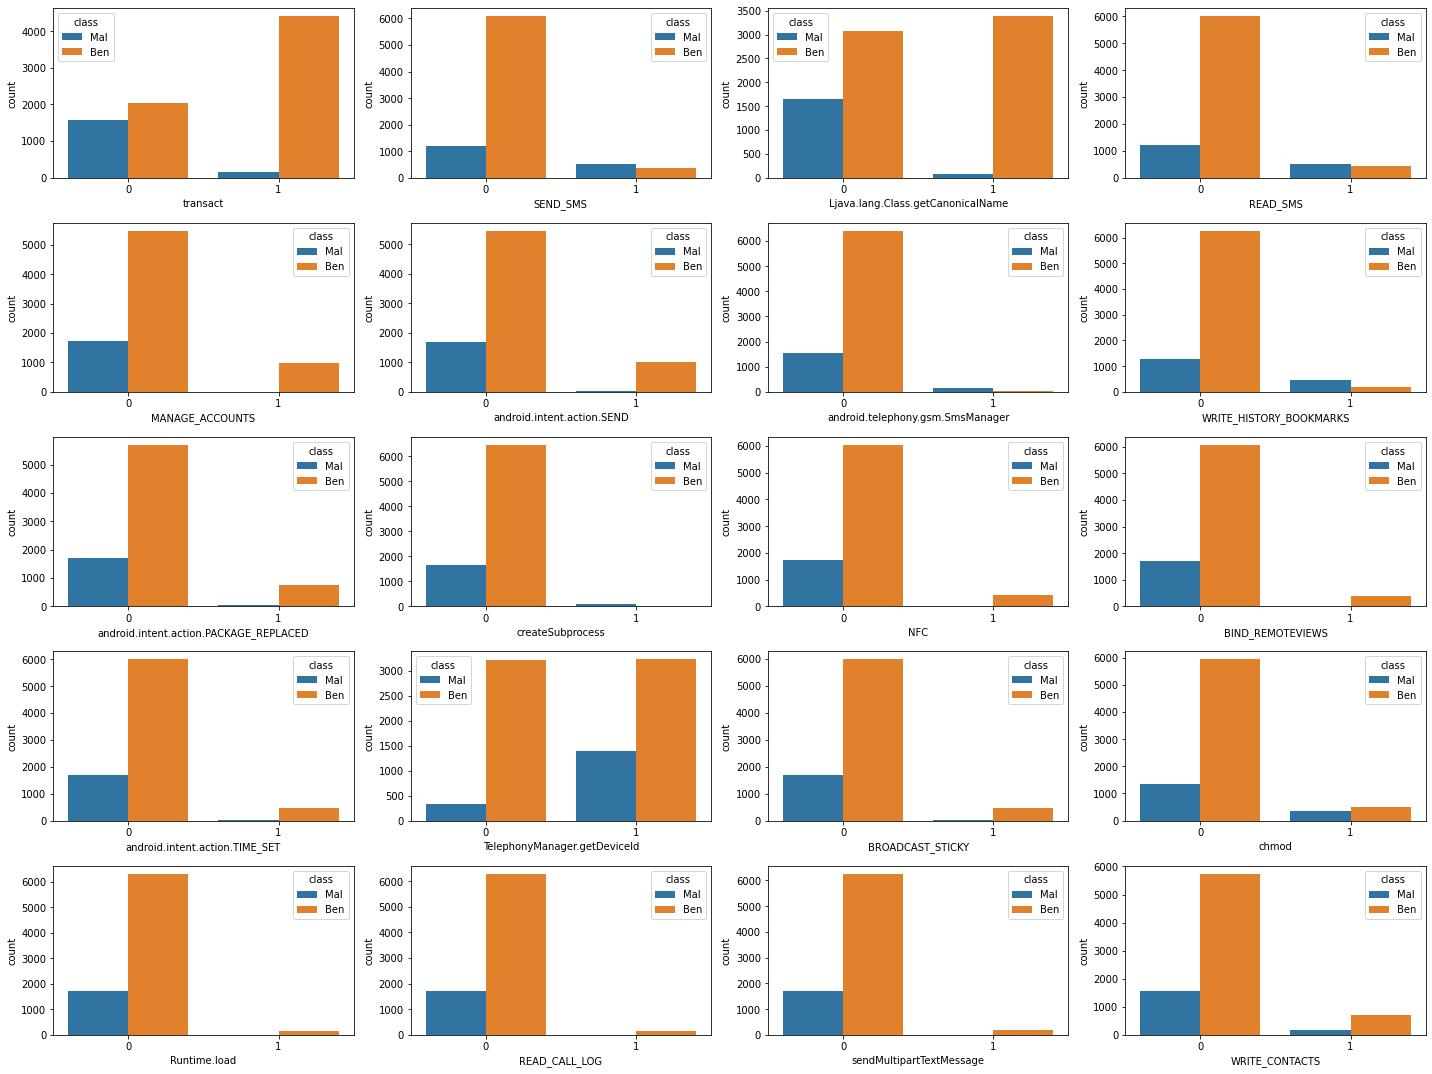

In [ ]:
count_plot(df, attrs_2)

##Criando as Variáveis de Treino e Teste

In [ ]:
#Checando a quantia de registros para cada classe do atributo target
# e definindo arrays contendo os seus valores

target_series = df[target].map({0:'Benigno', 1:'Malware'})
value_counts_target = target_series.value_counts()

labels_graph = list(value_counts_target.index.values)
values_graph = [value_counts_target[0], value_counts_target[1]]

print("Diferença entre classes:", (value_counts_target[0] - value_counts_target[1]))

Diferença entre classes: 4731


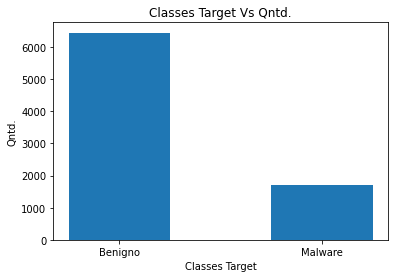

In [ ]:
plt.bar(labels_graph, values_graph, width=0.5)
plt.title('Classes Target Vs Qntd.')
plt.xlabel('Classes Target')
plt.ylabel('Qntd.')
plt.show()

Ao realizar a contagem de registros pertencentes a cada classe do atributo target, foi observado que existe uma diferença de 4.731 (6450 - 1719) registros.

Com o propósito de equilibrar a quantidade de registros de cada classe, foi adotada a estratégia de Random UnderSample, que reduzirá aleatoriamente a classe que contém mais registros. 

In [ ]:
X = df[attrs_2].values
y = df[target].values

In [ ]:
#Definindo estratégia de Under Sample
undersampler = RandomUnderSampler(sampling_strategy='majority')
X_samp, y_samp = undersampler.fit_resample(X, y)

#Split de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_samp, 
                                                    y_samp, 
                                                    test_size=0.3, 
                                                    random_state=143)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


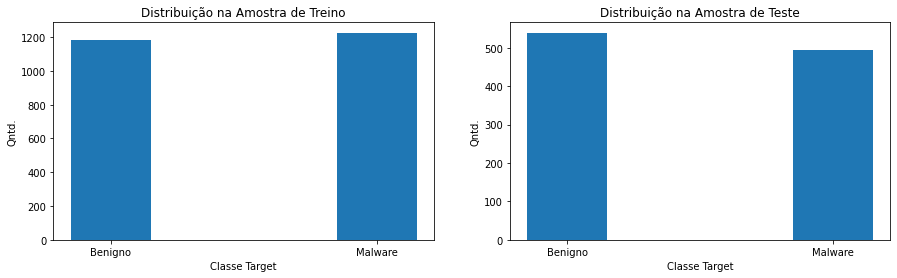

In [ ]:
(unique_samp_train, counts_samp_train) = np.unique(y_train, return_counts=True)
(unique_samp_test, counts_samp_test) = np.unique(y_test, return_counts=True)

unique_samp_train = ['Benigno' if item == 0 else 'Malware' for item in unique_samp_train]
unique_samp_test = ['Benigno' if item == 0 else 'Malware' for item in unique_samp_test]

plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.bar(unique_samp_train, counts_samp_train.tolist(), width=0.3)
plt.title('Distribuição na Amostra de Treino')
plt.xlabel('Classe Target')
plt.ylabel('Qntd.')

plt.subplot(1, 2, 2)
plt.title('Distribuição na Amostra de Teste')
plt.bar(unique_samp_test, counts_samp_test.tolist(), width=0.3)
plt.xlabel('Classe Target')
plt.ylabel('Qntd.')

plt.show()

##Aplicando Modelos de ML

###Categorical Naive Bayes

Justificativa da escolha do modelo: este modelo é adequado para classificação com atributos discretos categoricamente distribuídos.

In [ ]:
#Treinamento do modelo
model_cnb = CategoricalNB().fit(X_train, y_train)

In [ ]:
#Validação Cruzada do Modelo

cv = KFold(n_splits = 3, 
           shuffle = True, 
           random_state=0)

n_scores = cross_val_score(model_cnb, 
                           X_train, 
                           y_train, 
                           scoring = 'roc_auc', 
                           cv = cv)

print('Validação Cruzada - Categorical Naive Bayes:\n')
print(f'AUC Scores: {n_scores}')
print(f'AUC (média): {round(np.mean(n_scores), 2)}')
print(f'AUC (desvio padrão): {round(np.std(n_scores), 4)}')

Validação Cruzada - Categorical Naive Bayes:

AUC Scores: [0.96325457 0.95763007 0.96635308]
AUC (média): 0.96
AUC (desvio padrão): 0.0036


In [ ]:
print("Score do Modelo CNB:")
round(model_cnb.score(X, y), 2) 

Score do Modelo CNB:


0.83

In [ ]:
print(f'AUC (Treino): {round(roc_auc_score(y_train, model_cnb.predict(X_train)), 2)}')
print(f'AUC (Teste): {round(roc_auc_score(y_test, model_cnb.predict(X_test)), 2)}')

AUC (Treino): 0.87
AUC (Teste): 0.88


In [ ]:
y_pred_cnb = model_cnb.predict(X_test)
y_prob_pred_cnb = model_cnb.predict_proba(X_test)

count_misclassified = (y_test != y_pred_cnb).sum()

print("Total de amostras de teste:", len(y_test))
print('Amostras classificadas INCORRETAMENTE: {}'.format(count_misclassified))

Total de amostras de teste: 1032
Amostras classificadas INCORRETAMENTE: 131


--- Classification Report - Categorical Naive Bayes:
              precision    recall  f1-score   support

     Benigno       0.95      0.80      0.87       539
     Malware       0.81      0.96      0.88       493

    accuracy                           0.87      1032
   macro avg       0.88      0.88      0.87      1032
weighted avg       0.88      0.87      0.87      1032

--- Matriz de Confusão - Categorical Naive Bayes:


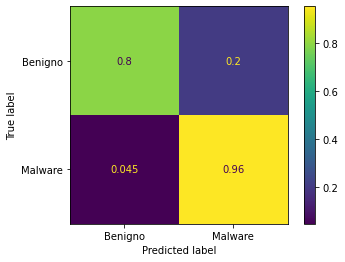

In [ ]:
print("--- Classification Report - Categorical Naive Bayes:")
print(classification_report(y_test, y_pred_cnb, target_names=['Benigno', 'Malware']))

print("--- Matriz de Confusão - Categorical Naive Bayes:")
plot_confusion_matrix(model_cnb, X_test, y_test, normalize='true', display_labels=['Benigno', 'Malware'])

###Bernoulli Naive Baiyes

Justificativa da escolha do modelo: o Bernoulli Naive Bayes foi projetado para lidar com atributos binários/booleanos.

In [ ]:
#Treinamento do modelo
model_bnb = BernoulliNB().fit(X_train, y_train)

In [ ]:
#Validação Cruzada do Modelo

cv = KFold(n_splits = 3, 
           shuffle = True, 
           random_state=0)

n_scores = cross_val_score(model_bnb, 
                           X_train, 
                           y_train, 
                           scoring = 'roc_auc', 
                           cv = cv)

print('Validação Cruzada - Bernoulli Naive Bayes:\n')
print(f'AUC Scores: {n_scores}')
print(f'AUC (média): {round(np.mean(n_scores), 2)}')
print(f'AUC (desvio padrão): {round(np.std(n_scores), 4)}')

Validação Cruzada - Bernoulli Naive Bayes:

AUC Scores: [0.96325457 0.95763007 0.96635308]
AUC (média): 0.96
AUC (desvio padrão): 0.0036


In [ ]:
print(f'AUC (Treino): {round(roc_auc_score(y_train, model_bnb.predict(X_train)), 2)}')
print(f'AUC (Teste): {round(roc_auc_score(y_test, model_bnb.predict(X_test)), 2)}')

AUC (Treino): 0.87
AUC (Teste): 0.88


In [ ]:
print("Score do Modelo BNB:")
round(model_bnb.score(X, y), 2) 

Score do Modelo BNB:


0.83

In [ ]:
y_pred_bnb = model_bnb.predict(X_test)
y_prob_pred_bnb = model_bnb.predict_proba(X_test)

count_misclassified = (y_test != y_pred_bnb).sum()

print("Total de amostras de teste:", len(y_test))
print('Amostras classificadas INCORRETAMENTE: {}'.format(count_misclassified))

Total de amostras de teste: 1032
Amostras classificadas INCORRETAMENTE: 131


--- Classification Report - Bernoulli Naive Bayes:
              precision    recall  f1-score   support

     Benigno       0.95      0.80      0.87       539
     Malware       0.81      0.96      0.88       493

    accuracy                           0.87      1032
   macro avg       0.88      0.88      0.87      1032
weighted avg       0.88      0.87      0.87      1032

--- Matriz de Confusão - Bernoulli Naive Bayes:


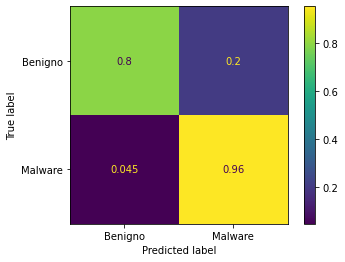

In [ ]:
print("--- Classification Report - Bernoulli Naive Bayes:")
print(classification_report(y_test, y_pred_bnb, target_names=['Benigno', 'Malware']))

print("--- Matriz de Confusão - Bernoulli Naive Bayes:")
plot_confusion_matrix(model_bnb, X_test, y_test, normalize='true', display_labels=['Benigno', 'Malware'])

###PCA com SVC

Justificativa do uso do modelo:

In [ ]:
#Todos os componentes serão mantidos, visto que o dataframe fora reduzido anteriormente.
pca = PCA(random_state=42) 

svm1 = SVC(kernel='linear', probability=True)

model_pca = make_pipeline(pca, svm1).fit(X_train, y_train)

In [ ]:
#Validação Cruzada do Modelo

cv = KFold(n_splits = 3, 
           shuffle = True, 
           random_state=0)

n_scores = cross_val_score(model_pca, 
                           X_train, 
                           y_train, 
                           scoring = 'roc_auc', 
                           cv = cv)

print('Validação Cruzada - PCA:\n')
print(f'AUC Scores: {n_scores}')
print(f'AUC (média): {round(np.mean(n_scores), 2)}')
print(f'AUC (desvio padrão): {round(np.std(n_scores), 4)}')

Validação Cruzada - PCA:

AUC Scores: [0.96503534 0.96224795 0.96721966]
AUC (média): 0.96
AUC (desvio padrão): 0.002


In [ ]:
print("Score do Modelo PCA:")
round(model_pca.score(X, y), 2) 

Score do Modelo PCA:


0.93

In [ ]:
print(f'AUC (Treino): {round(roc_auc_score(y_train, model_pca.predict(X_train)), 2)}')
print(f'AUC (Teste): {round(roc_auc_score(y_test, model_pca.predict(X_test)), 2)}')

AUC (Treino): 0.91
AUC (Teste): 0.93


In [ ]:
y_pred_pca = model_pca.predict(X_test)
y_prob_pred_pca = model_pca.predict_proba(X_test)

count_misclassified = (y_test != y_pred_pca).sum()

print("Total de amostras de teste:", len(y_test))
print('Amostras classificadas INCORRETAMENTE: {}'.format(count_misclassified))

Total de amostras de teste: 1032
Amostras classificadas INCORRETAMENTE: 70


--- Classification Report - PCA:
              precision    recall  f1-score   support

     Benigno       0.92      0.95      0.94       539
     Malware       0.94      0.91      0.93       493

    accuracy                           0.93      1032
   macro avg       0.93      0.93      0.93      1032
weighted avg       0.93      0.93      0.93      1032

--- Matriz de Confusão - PCA:


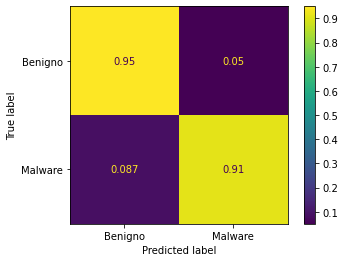

In [ ]:
print("--- Classification Report - PCA:")
print(classification_report(y_test, y_pred_pca, target_names=['Benigno', 'Malware']))

print("--- Matriz de Confusão - PCA:")
plot_confusion_matrix(model_pca, X_test, y_test, normalize='true', display_labels=['Benigno', 'Malware'])

###LDA

Justificativa do uso do modelo: fim comparativo com o rendimento do PCA. 

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=1)

svm2 = SVC(kernel='linear', probability=True)

model_lda = make_pipeline(lda, svm2).fit(X_train, y_train)

In [ ]:
#Validação Cruzada do Modelo

cv = KFold(n_splits = 3, 
           shuffle = True, 
           random_state=0)

n_scores = cross_val_score(model_lda, 
                           X_train, 
                           y_train, 
                           scoring = 'roc_auc', 
                           cv = cv)

print('Validação Cruzada - LDA:\n')
print(f'AUC Scores: {n_scores}')
print(f'AUC (média): {round(np.mean(n_scores), 2)}')
print(f'AUC (desvio padrão): {round(np.std(n_scores), 4)}')

Validação Cruzada - LDA:

AUC Scores: [0.962414   0.95698905 0.96423339]
AUC (média): 0.96
AUC (desvio padrão): 0.0031


In [ ]:
print("Score do Modelo LDA:")
round(model_lda.score(X, y), 2) 

Score do Modelo LDA:


0.92

In [ ]:
print(f'AUC (Treino): {round(roc_auc_score(y_train, model_lda.predict(X_train)), 2)}')
print(f'AUC (Teste): {round(roc_auc_score(y_test, model_lda.predict(X_test)), 2)}')

AUC (Treino): 0.9
AUC (Teste): 0.92


In [ ]:
y_pred_lda = model_lda.predict(X_test)
y_prob_pred_lda = model_lda.predict_proba(X_test)

count_misclassified = (y_test != y_pred_lda).sum()

print("Total de amostras de teste:", len(y_test))
print('Amostras classificadas INCORRETAMENTE: {}'.format(count_misclassified))

Total de amostras de teste: 1032
Amostras classificadas INCORRETAMENTE: 82


--- Classification Report - LDA:
              precision    recall  f1-score   support

     Benigno       0.91      0.94      0.92       539
     Malware       0.93      0.90      0.92       493

    accuracy                           0.92      1032
   macro avg       0.92      0.92      0.92      1032
weighted avg       0.92      0.92      0.92      1032

--- Matriz de Confusão - LDA:


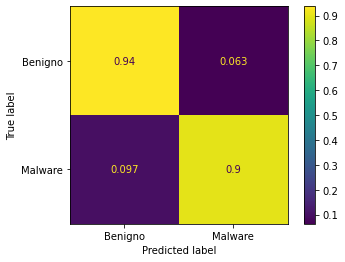

In [ ]:
print("--- Classification Report - LDA:")
print(classification_report(y_test, y_pred_lda, target_names=['Benigno', 'Malware']))

print("--- Matriz de Confusão - LDA:")
plot_confusion_matrix(model_lda, X_test, y_test, normalize='true', display_labels=['Benigno', 'Malware'])

###GridSearchCV com PCA e SVC

Justificativa do uso do modelo: a aplicação do GridSearch foi motivada pela preferência nos melhores parâmetros para o SCV.

In [ ]:
pca_grid = PCA(whiten='True', random_state=42)

svc_grid = SVC(kernel='linear', probability=True)

model_grid = make_pipeline(pca_grid, svc_grid)

In [ ]:
#Tuning final dos parâmetros do GridSearch
param_grid = {'svc__C': [0.23, 0.24, 0.25],
              #'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
              'svc__gamma': [0.000000000000001, 0.000000000000001 , 0.0000000000001]}

grid = GridSearchCV(model_grid, param_grid, cv=5)

%time grid.fit(X_train, y_train)

print(grid.best_params_)

CPU times: user 11.8 s, sys: 5.1 s, total: 16.9 s
Wall time: 10.9 s
{'svc__C': 0.24, 'svc__gamma': 1e-15}


In [ ]:
model_best_grid = grid.best_estimator_
print(model_best_grid)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=42, svd_solver='auto', tol=0.0,
                     whiten='True')),
                ('svc',
                 SVC(C=0.24, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=1e-15,
                     kernel='linear', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)


In [ ]:
print("Score do modelo com GridSearchCV:")
round(model_best_grid.score(X, y), 2) 

Score do modelo com GridSearchCV:


0.93

In [ ]:
print(f'AUC (Treino): {round(roc_auc_score(y_train, model_best_grid.predict(X_train)), 2)}')
print(f'AUC (Teste): {round(roc_auc_score(y_test, model_best_grid.predict(X_test)), 2)}')

AUC (Treino): 0.91
AUC (Teste): 0.93


In [ ]:
y_pred_grid = model_best_grid.predict(X_test)
y_prob_pred_grid = model_best_grid.predict_proba(X_test)

count_misclassified = (y_test != y_pred_grid).sum()

print("Total de amostras de teste:", len(y_test))
print('Amostras classificadas INCORRETAMENTE: {}'.format(count_misclassified))

Total de amostras de teste: 1032
Amostras classificadas INCORRETAMENTE: 70


--- Classification Report - GridSearchCV:
              precision    recall  f1-score   support

     Benigno       0.92      0.95      0.94       539
     Malware       0.94      0.91      0.93       493

    accuracy                           0.93      1032
   macro avg       0.93      0.93      0.93      1032
weighted avg       0.93      0.93      0.93      1032

--- Matriz de Confusão - GridSearchCV:


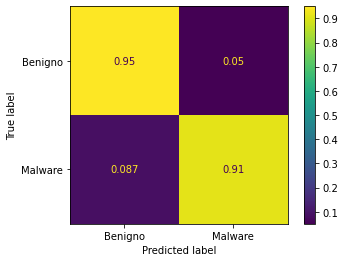

In [ ]:
print("--- Classification Report - GridSearchCV:")
print(classification_report(y_test, y_pred_grid, target_names=['Benigno', 'Malware']))

print("--- Matriz de Confusão - GridSearchCV:")
plot_confusion_matrix(model_best_grid, X_test, y_test, normalize='true', display_labels=['Benigno', 'Malware'])

##Considerações Finais

Os modelos de Naive Bayes tiveram exatamente a mesma performance (métricas de avaliação, acertos e erros na matriz de confusão), mostrando que a aplicação de Categorical NB foi redudante. Em comparação aos outros modelos criados, os de Naive Bayes foram os de performance mais baixa. 

O modelo de PCA, usando SVC como estimador em uma pipeline, errou mais ao classificar os softwares malignos. Sua performance foi sutilmente melhor que o modelo de LDA. Possivelmente porque o LDA faz uso de densidade gaussiana, mais apropriada para atributos com valores reais. Uma outra razão pode estar na quantidade de amostra, já que LDA se saia melhor que PCA quando Random OverSample foi utilizado.

Curiosamente, dois modelos tiveram a mesma performance: o PCA e a pipeline de PCA e SVC aplicada ao GridSearch: ambos tiveram os mesmos valores nas métricas de avaliação, na validação cruzada, matriz de confusão e na quantificação de amostras classficadas incorretamente. Isso mostra que aplicar os melhores parâmetros C e gamma, de acordo com o GridSearchCV, não impactou no rendimento do PCA com SVC.

Para este trabalho, o uso do Random UnderSample foi preferido por mostrar melhor rendimento na maioria dos modelos empregados. Como trabalho futuro, é considerada a possibilidade de utilizar modelos de ML mais simples, como KNN, para fins de comparação de desempenho. 

##Referências Bibliográficas

https://www.kaggle.com/shashwatwork/android-malware-dataset-for-machine-learning

S. Y. Yerima and S. Sezer, "DroidFusion: A Novel Multilevel Classifier Fusion Approach for Android Malware Detection," in *IEEE Transactions on Cybernetics*, vol. 49, no. 2, pp. 453-466, Feb. 2019, doi: 10.1109/TCYB.2017.2777960.



https://scikit-learn.org/stable/modules/feature_selection.html

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html